In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import Model, Sequential, models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

import sys
sys.path.append('../utility_packages/')
from image_utils import label_images, plot_images, count_samples

np.random.seed(6)

In [6]:
# define datasets and sample size
train_data_dir = "../data/seg_train/"
test_data_dir = "../data/seg_test/"

# define datasets and sample size
num_train_samples = count_samples(train_data_dir)
num_test_samples = count_samples(test_data_dir)

# define image dimensions
img_width, img_height = 150, 150
img_target_size = (img_width, img_height)

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

In [7]:
training_imgs, labeled_training_imgs = label_images(train_data_dir, '.jpg')

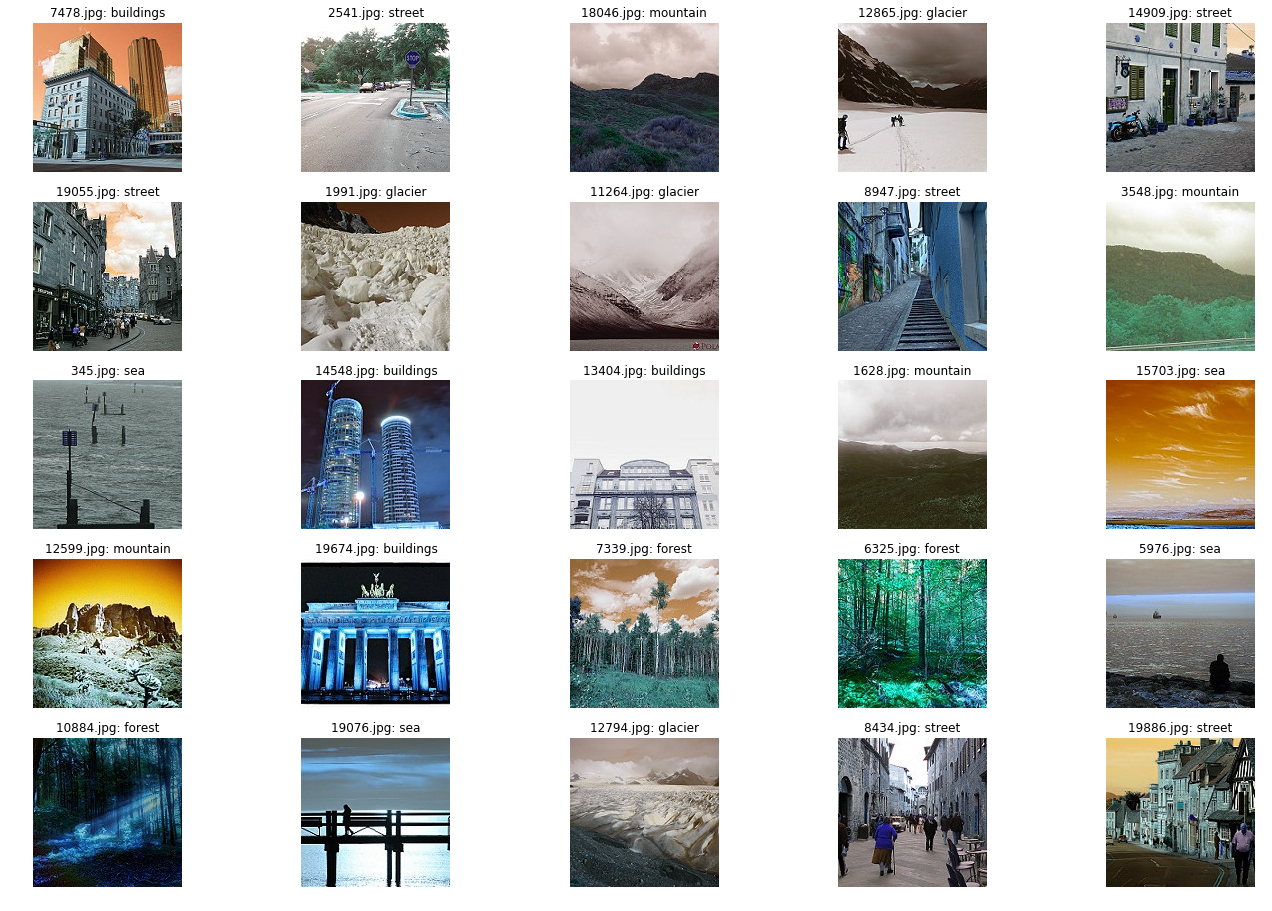

In [8]:
plot_images(training_imgs, labeled_training_imgs)

In [ ]:
# define model hyperparameters
epochs = 3
batch_size = 64
neurons_per_layer = [600, 500, 400, 300]
dropout = 0.25
n_classes = 6
patience = 3

# specify image augmentation
img_augmentation = ImageDataGenerator(preprocessing_function=preprocess_input,
      rotation_range=90,
      horizontal_flip=True,
      vertical_flip=True)

# prepare train/test data generators
train_data = img_augmentation.flow_from_directory(
    train_data_dir,
    target_size = img_target_size,
    batch_size = batch_size,
    class_mode = 'categorical')

test_data = img_augmentation.flow_from_directory(
    test_data_dir,
    target_size = img_target_size,
    batch_size = batch_size,
    class_mode = 'categorical')

In [ ]:
# specify base model and freeze weights
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

# create model function
def create_model(base_model, dropout, neurons_per_layer, num_classes):
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = layers.Flatten()(x)
    
    for num_neurons in neurons_per_layer:
        x = layers.Dense(num_neurons, activation='relu')(x) 
        x = layers.Dropout(dropout)(x)

    classifications = layers.Dense(num_classes, activation='softmax')(x) 
    model = Model(inputs=base_model.input, outputs=classifications)
    
    # compile model
    model.compile(loss='categorical_crossentropy', optimizer="SGD", metrics=['acc'])

    return model

# instantiate model
model = create_model(base_model, dropout=dropout, neurons_per_layer=neurons_per_layer, num_classes=n_classes)

callbacks = [EarlyStopping(monitor='val_acc', patience=patience),
             ModelCheckpoint(filepath='resnet_intel_model.h5', monitor='val_acc', save_best_only=True)]

# train model
model.fit_generator(
    train_data,
    steps_per_epoch = num_train_samples // batch_size,
    validation_data = test_data,
    validation_steps = num_test_samples // batch_size,
    epochs = epochs,
    callbacks = callbacks,
    use_multiprocessing = True)

In [ ]:
plot.plot(model.history['acc'])
plot.plot(model.history['val_acc'])
plot.title('Model accuracy')
plot.ylabel('Accuracy')
plot.xlabel('Epoch')
plot.legend(['Train', 'Test'], loc='upper left')
plot.show()

plot.plot(model.history['loss'])
plot.plot(model.history['val_loss'])
plot.title('Model loss')
plot.ylabel('Loss')
plot.xlabel('Epoch')
plot.legend(['Train', 'Test'], loc='upper left')
plot.show()

In [ ]:
test_score = model.evaluate_generator(test_data,
    steps = num_test_samples // batch_size,
    use_multiprocessing=True)

print("Test loss {:.4f}, accuracy {:.2f}%".format(test_score[0], test_score[1] * 100))